# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


In [1]:
# 0) Chargement des bibliothèques + seed
# --------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Pour la régression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Pour le réseau de neurones (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Fixation du seed pour la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded and random seed fixed.")



Libraries loaded and random seed fixed.


# 1) Lecture des données (depuis l'URL) et prétraitement

In [ ]:
# ------------------------------------------------------

# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime (si ce n'est pas déjà le cas)
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

# Affichage des premières lignes et dimensions
print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

# Retirer les lignes contenant des NaN dans la colonne 'Price'
df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

# Vérification après nettoyage
print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


# 2) Feature Engineering

In [40]:
# ----------------------
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante n = 3 * 25

df = df_raw.copy()

# 2.1 Rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df.dropna(inplace=True)  # retire la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
# Filtrons si la base est trop courte pour calculer 3 ans
K_list = [K for K in K_list if K < len(df)]

# Calculs (moyenne mobile des rendements + volatilité annualisée)
for K in K_list:
    # Moyenne des K derniers rendements
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)

    # Volatilité annualisée sur K derniers rendements
    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"].fillna(method="bfill", inplace=True)


# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"].fillna(method="bfill", inplace=True)

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df.dropna(inplace=True)

# 2.6 Cible = Rendement futur R_{t+1}

df["FutureReturn"] = df["Return"].shift(-1)
df.dropna(inplace=True)

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")




C:\Users\ugo11\AppData\Local\Temp\ipykernel_23788\933299551.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
C:\Users\ugo11\AppData\Local\Temp\ipykernel_23788\933299551.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
C:\Users\ugo11\AppData\Local\Temp\ipykernel_23788\933299551.py:26: FutureWarning: A value is trying to be


Dimensions après feature engineering : (7262, 96)
Feature scaling terminé.


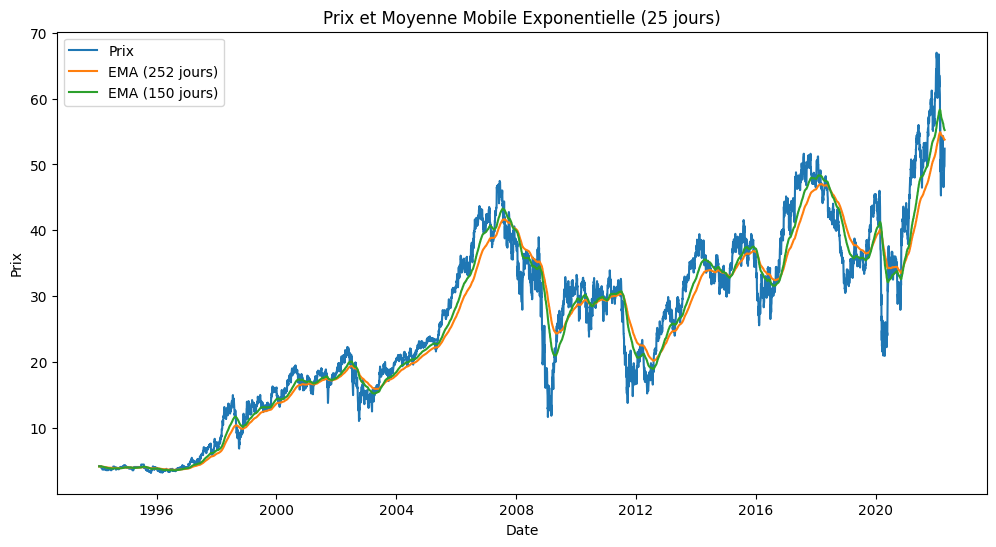

In [42]:
# Exemple de visualisation : prix et EMA

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle (25 jours)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()


In [15]:
# 3) Séparation temporelle (Train=80%, Test=20%)
# ----------------------------------------------
N = len(df)
Nt = int(0.8 * N)
Nv = N - Nt

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)





Taille dataset complet : 7332
Taille train : 5865
Taille test : 1467


In [28]:
# Régression linéaire
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Évaluation des performances
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"\nRégression Linéaire - MSE test : {mse_lin:.6f}")



Régression Linéaire - MSE test : 0.000457


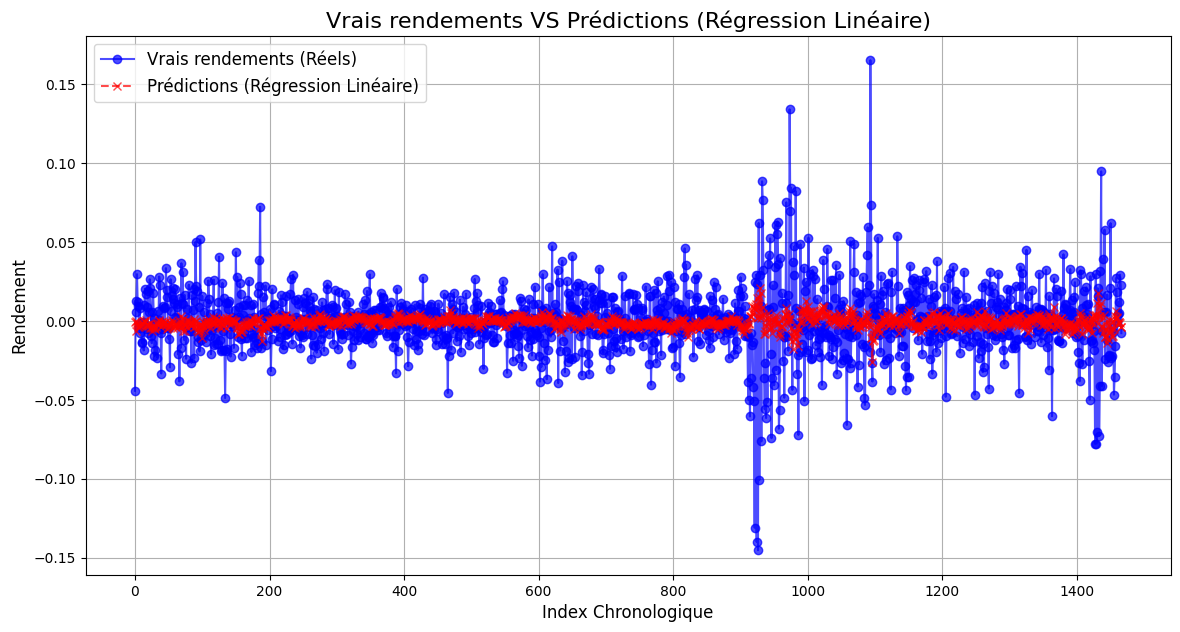

In [39]:
import matplotlib.pyplot as plt

# Tracé des vrais rendements et des prédictions
plt.figure(figsize=(14, 7))

# Tracer les vrais rendements
plt.plot(range(len(y_test)), y_test, label="Vrais rendements (Réels)", color='blue', linestyle='-', marker='o', alpha=0.7)

# Tracer les prédictions
plt.plot(range(len(y_pred_lin)), y_pred_lin, label="Prédictions (Régression Linéaire)", color='red', linestyle='--', marker='x', alpha=0.7)

# Ajouter des titres et légendes
plt.title("Vrais rendements VS Prédictions (Régression Linéaire)", fontsize=16)
plt.xlabel("Index Chronologique", fontsize=12)
plt.ylabel("Rendement", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Afficher le graphique
plt.show()


In [29]:
# Construction du modèle
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Rendement futur (valeur continue)
])

# Compilation du modèle
model.compile(optimizer='adam', loss='mse')

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Nombre d'époques
    batch_size=32,  # Taille du batch
    verbose=1
)

# Évaluation des performances
mse_nn = model.evaluate(X_test, y_test, verbose=0)
print(f"\nRéseau de Neurones - MSE test : {mse_nn:.6f}")


c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0384 - val_loss: 0.0149
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0091
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025 - val_loss: 0.0074
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 0.0051
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 0.0032
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.3982e-04 - val_loss: 0.0024
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

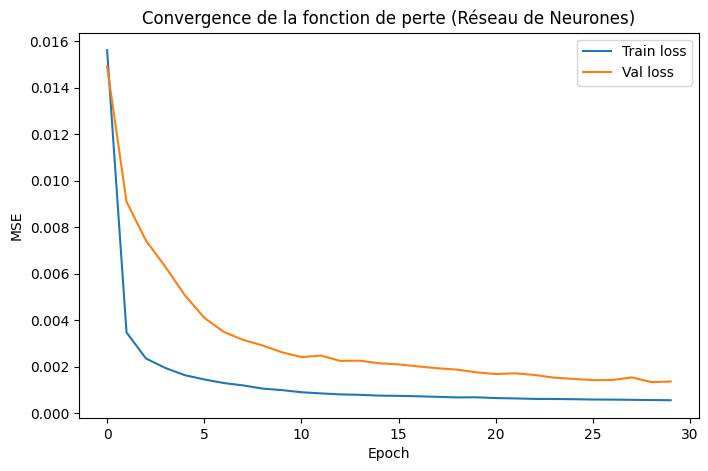

In [30]:
# Graphique de convergence de la fonction de perte (Réseau de Neurones)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Convergence de la fonction de perte (Réseau de Neurones)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


In [33]:
from tensorflow.keras.layers import LSTM

# Construction du modèle LSTM
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(32),
    Dense(1, activation='linear')
])

# Compilation du modèle
model_lstm.compile(optimizer='adam', loss='mse')

# Entraînement
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,  # Nombre d'époques
    batch_size=32,  # Taille du batch
    verbose=1
)

# Évaluation des performances
mse_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print(f"\nRéseau de Neurones - MSE test : {mse_nn:.6f}")


c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 6.9062e-04 - val_loss: 4.6593e-04
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 5.9433e-04 - val_loss: 4.5412e-04
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 5.7978e-04 - val_loss: 4.5052e-04
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 5.7187e-04 - val_loss: 4.5241e-04
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 5.7071e-04 - val_loss: 4.5393e-04
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 5.7208e-04 - val_loss: 4.5370e-04
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 5.7140e-04 - val_loss: 4.5335e-04
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.6956e-04 - val_loss: 4.5217e-04
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.6788e-04 - val_loss: 4.5001e-04
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 5.6659e-04 - val_loss: 4.4781e-04
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms

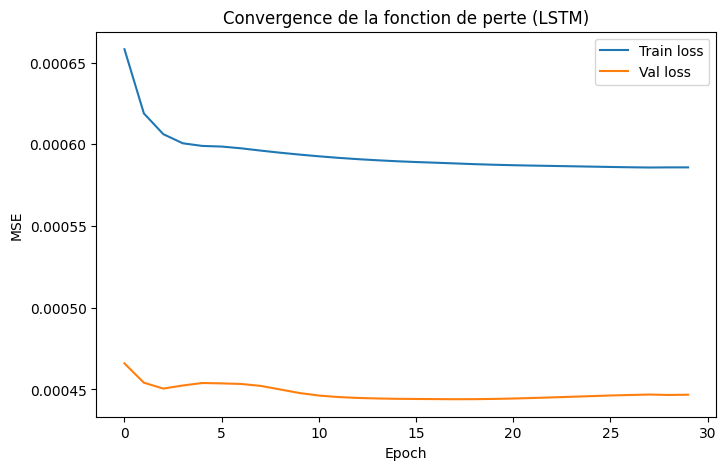

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history['loss'], label='Train loss')
plt.plot(history_lstm.history['val_loss'], label='Val loss')
plt.title("Convergence de la fonction de perte (LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


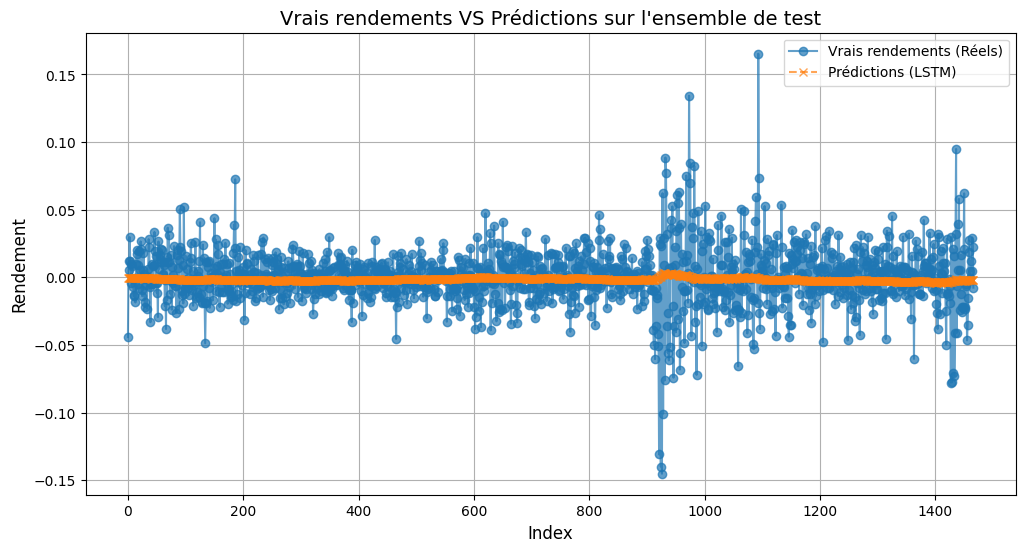

In [35]:
# Reshape des données de test pour le LSTM
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Prédictions sur l'ensemble de test
y_pred = model_lstm.predict(X_test_lstm)

# Si les données ont été normalisées, inverser la normalisation
# Supposons que vous avez utilisé StandardScaler pour normaliser `y`
# y_scaler.inverse_transform(...) permet de récupérer les vraies valeurs
# Si aucune mise à l'échelle n'a été effectuée, ignorez cette étape
y_test_true = y_test  # Vraies valeurs (utiliser une inversion si scalées)
y_pred_true = y_pred.flatten()  # Aplatir les prédictions

# Tracé des vraies valeurs vs prédictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_true, label="Vrais rendements (Réels)", linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred_true, label="Prédictions (LSTM)", linestyle='--', marker='x', alpha=0.7)
plt.title("Vrais rendements VS Prédictions sur l'ensemble de test", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Rendement", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


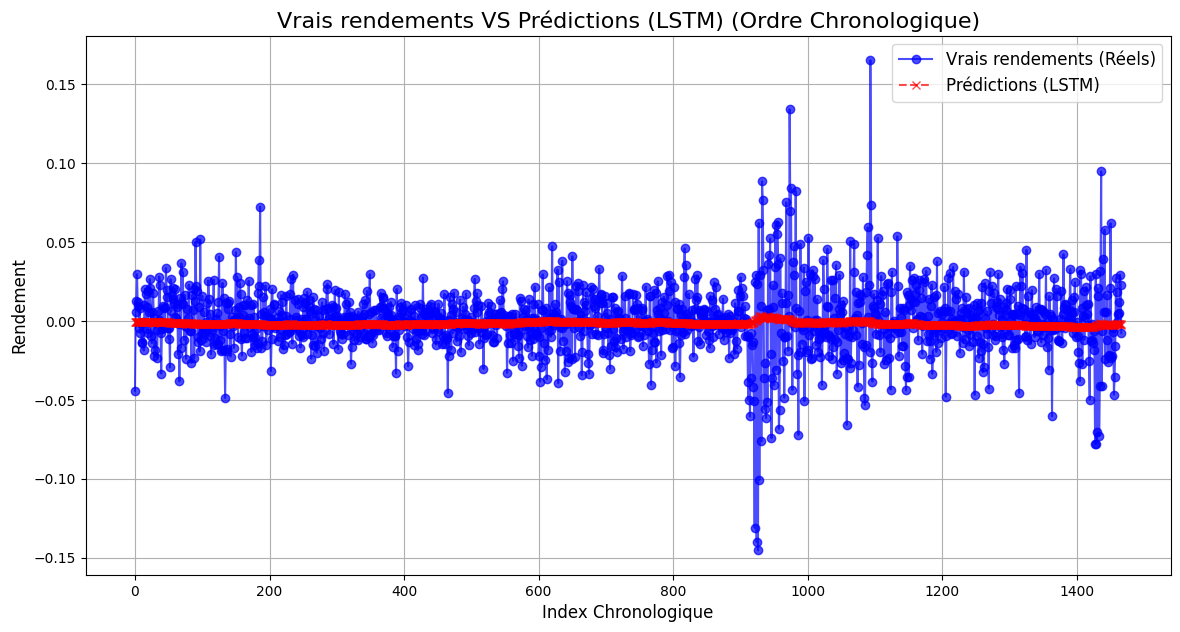

In [38]:
import matplotlib.pyplot as plt

# Assurez-vous que y_test et y_pred contiennent les vrais rendements et prédictions dans l'ordre chronologique
# Si nécessaire, re-triez vos données ou votre DataFrame d'origine avant de diviser en train/test.

plt.figure(figsize=(14, 7))

# Tracer les vraies valeurs des rendements (ordre chronologique)
plt.plot(range(len(y_test)), y_test, label="Vrais rendements (Réels)", color='blue', linestyle='-', marker='o', alpha=0.7)

# Tracer les prédictions (ordre chronologique correspondant)
plt.plot(range(len(y_pred)), y_pred.flatten(), label="Prédictions (LSTM)", color='red', linestyle='--', marker='x', alpha=0.7)

# Ajouter des titres et légendes
plt.title("Vrais rendements VS Prédictions (LSTM) (Ordre Chronologique)", fontsize=16)
plt.xlabel("Index Chronologique", fontsize=12)
plt.ylabel("Rendement", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Afficher le graphique
plt.show()


In [36]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_true, y_pred_true)
print(f"MAE des prédictions : {mae:.6f}")


MAE des prédictions : 0.014172


In [17]:
# 5) Étude d'ablation (exemples)
# ------------------------------
# Exemple : a) Retrait des colonnes "emaRatio_*"
mse_ablation = {}

cols_no_ema = [c for c in feature_cols if not c.startswith("emaRatio_")]
X_no_ema = df[cols_no_ema].values
X_no_ema_scaled = scaler.fit_transform(X_no_ema)

X_no_ema_train, X_no_ema_test = X_no_ema_scaled[:Nt], X_no_ema_scaled[Nt:]
y_train2, y_test2 = y_train, y_test

linreg2 = LinearRegression()
linreg2.fit(X_no_ema_train, y_train2)
mse_lin2 = mean_squared_error(y_test2, linreg2.predict(X_no_ema_test))
mse_ablation["NoEMA_LinReg"] = mse_lin2

# b) Retrait des colonnes "meanRet_*"
cols_no_meanRet = [c for c in feature_cols if not c.startswith("meanRet_")]
X_no_meanRet = df[cols_no_meanRet].values
X_no_meanRet_scaled = scaler.fit_transform(X_no_meanRet)

X_no_meanRet_train, X_no_meanRet_test = X_no_meanRet_scaled[:Nt], X_no_meanRet_scaled[Nt:]
linreg3 = LinearRegression()
linreg3.fit(X_no_meanRet_train, y_train2)
mse_lin3 = mean_squared_error(y_test2, linreg3.predict(X_no_meanRet_test))
mse_ablation["NoMeanRet_LinReg"] = mse_lin3

print("\n=== Étude d'ablation ===")
for k, v in mse_ablation.items():
    print(f"{k}: MSE = {v:.6f}")





=== Étude d'ablation ===
NoEMA_LinReg: MSE = 0.000456
NoMeanRet_LinReg: MSE = 0.000458


In [18]:
# 6) Sauvegarde du modèle et des données
# --------------------------------------
os.makedirs("save_model", exist_ok=True)

# Sauvegarde du DataFrame complet
df.to_csv("save_model/my_dataset.csv", index=True)

# Sauvegarde du modèle Keras
model.save("save_model/my_model.h5")

print("\nSauvegarde des données et du modèle terminée.")


# 7) Comparaison finale des performances
# --------------------------------------
print("\n=== Comparaison finale des MSE ===")
print(f"LinReg MSE       : {mse_lin:.6f}")
print(f"NeuralNet MSE    : {mse_nn:.6f}")
print("Ablation exemples : ", mse_ablation)




Sauvegarde des données et du modèle terminée.

=== Comparaison finale des MSE ===
LinReg MSE       : 0.000457
NeuralNet MSE    : 0.001668
Ablation exemples :  {'NoEMA_LinReg': 0.00045590084884430466, 'NoMeanRet_LinReg': 0.0004579277967065355}

Fin du notebook.
